In [46]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import palettable as pltt
import seaborn as sns
from seaborn import palplot
import pandas as pd
from pysal.lib import weights
import numpy as np

from sklearn import cluster
from sklearn.cluster import KMeans


### Data Loading

In [47]:
# Data file paths
health_infra_dta_path = 'data/Hospital/ddl_health_infra_2011.dta'

# Read dta file in
health_infra_df = pd.read_stata(health_infra_dta_path)

# Display top of table
health_infra_df.head()

,pc11_district_id,pc11_district_name,pc11_state_id,pc11_state_name,count_2011_sub,count_2011_dish,count_2011_sth,count_2011_phc,count_2011_chc,pr_2011_phc,pr_2011_chc,pr_2011_sub,pr_2011_dish,pr_2011_sth
0,001,Kupwara,1,Jammu & Kashmir,157,1,0,32,6,0.344717,0.064634,1.691268,0.010772,0.0
1,002,Badgam,1,Jammu & Kashmir,139,1,0,56,8,0.696582,0.099512,1.729016,0.012439,0.0
2,003,LehLadakh,1,Jammu & Kashmir,122,1,0,15,3,1.053564,0.210713,8.568987,0.070238,0.0
3,004,Kargil,1,Jammu & Kashmir,118,1,0,16,4,1.065417,0.266354,7.857453,0.066589,0.0
4,005,Punch,1,Jammu & Kashmir,155,1,0,34,4,0.668528,0.078650,3.047700,0.019663,0.0


### Data Documentation

Health Infrastructure: These data were available on Government of India’s Open Government Data Platform (https://data.gov.in/catalog/all-india-health-centres-directory?filters%5Bfield_catalog_reference%5D=3786581&format=json&offset=0&limit=6&sort%5Bcreated%5D=desc) and reflect the distribution of health infrastructure on 7th October 2016.

We export these data into ArcGIS where we join these data with shapefiles for district boundaries in 2011 (census year) and 2019 (latest) to obtain the count of number of facilities of each type at the district level.  

Population data in 2016: To get the facilities per 10000 population, we merge these data with the population data in 2016. We use geocoded population data from Gridded Population of the World, Version 4 (GPWv4) hosted at the Socioeconomic Data and Applications Center (SEDAC) (https://sedac.ciesin.columbia.edu/theme/population). This database contains gridded population data at the sub-district level from the 2011 Census. We estimated aggregate population in 2016 using the population growth rates calculated from the US Census Bureau’s estimates for India (https://www.census.gov/data-tools/demo/idb/informationGateway.php).


|   Variable Name                   |             Definition                                                         |
|-----------------------------------|--------------------------------------------------------------------------------|
|pc11_district_id                   |2011 Census District ID                                                         |
|pc11_district_name                 |2011 Census District name                                                       |
|pc11_state_id                      |2011 Census State ID                                                            |
|pc11_state_name                    |2011 Census State Name                                                          |
|count_2011_sub                     |Number of sub-centres in the district in 2016                                   |
|count_2011_dish                    |Number of district hospitals in the district in 2016                            |
|count_2011_sth                     |Number of sub-district/taluk hospitals in the district in 2016                  |
|count_2011_phc                     |Number of primary health centers in the district in 2016                        |
|count_2011_chc                     |Number of community health centers in the district in 2016                      | 
|pr_2011_phc                        |Number of primary health centers per 10000 people in the district in 2016       |
|pr_2011_chc                        |Number of community health centers per 10000 people in the district in 2016     |
|pr_2011_sub                        |Number of sub-centres per 10000 people in the district in 2016                  |
|pr_2011_dish                       |Number of district hospitals per 10000 people in the district in 2016           |
|pr_2011_sth                        |Number of sub-district/taluk hospitals per 10000 people in the district in 2016 |


In [48]:
# General info
health_infra_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 0 to 639
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pc11_district_id    640 non-null    object 
 1   pc11_district_name  640 non-null    object 
 2   pc11_state_id       640 non-null    int8   
 3   pc11_state_name     640 non-null    object 
 4   count_2011_sub      640 non-null    int16  
 5   count_2011_dish     640 non-null    int8   
 6   count_2011_sth      640 non-null    int8   
 7   count_2011_phc      640 non-null    int16  
 8   count_2011_chc      640 non-null    int8   
 9   pr_2011_phc         640 non-null    float32
 10  pr_2011_chc         640 non-null    float32
 11  pr_2011_sub         640 non-null    float32
 12  pr_2011_dish        640 non-null    float32
 13  pr_2011_sth         640 non-null    float32
dtypes: float32(5), int16(2), int8(4), object(3)
memory usage: 37.5+ KB


***There are no NaN, all districts have data***

### Transforming the Data
- Droping the name and count columns
- Ranaming the rest of the columns
- Changing the type of the 'pc11_district_id' (couldn't be merged as object)
- Setting the index column

In [49]:
# Droping the count columns and district and state names columns
health_infra_df = health_infra_df.drop([ 'pc11_district_name', 'pc11_state_name', 'count_2011_sub', 'count_2011_dish', 
                                      'count_2011_sth', 'count_2011_phc', 'count_2011_chc' ], axis = 1
                                    )
# renameing columns
health_infra_df = health_infra_df.rename( columns = {'pr_2011_phc' : 'primery_health_centers',
                                                'pr_2011_chc' : 'community_health_centers',
                                                'pr_2011_sub' : 'sub_centers',
                                                'pr_2011_dish': 'district_hospitals',
                                                'pr_2011_sth' : 'sub_taluk_hospitals'
                                               }
                                      )
# Change type
health_infra_df.pc11_district_id = health_infra_df.pc11_district_id.astype(int)

# Set index
health_infra_df = health_infra_df.set_index('pc11_district_id')

# Display top of table
health_infra_df.head()

,pc11_state_id,primery_health_centers,community_health_centers,sub_centers,district_hospitals,sub_taluk_hospitals
pc11_district_id,,,,,,
1,1,0.344717,0.064634,1.691268,0.010772,0.0
2,1,0.696582,0.099512,1.729016,0.012439,0.0
3,1,1.053564,0.210713,8.568987,0.070238,0.0
4,1,1.065417,0.266354,7.857453,0.066589,0.0
5,1,0.668528,0.078650,3.047700,0.019663,0.0


In [50]:
main_indicators = ['primery_health_centers','community_health_centers','district_hospitals','sub_taluk_hospitals']
all_indicators = ['primery_health_centers','community_health_centers','sub_centers','district_hospitals','sub_taluk_hospitals']

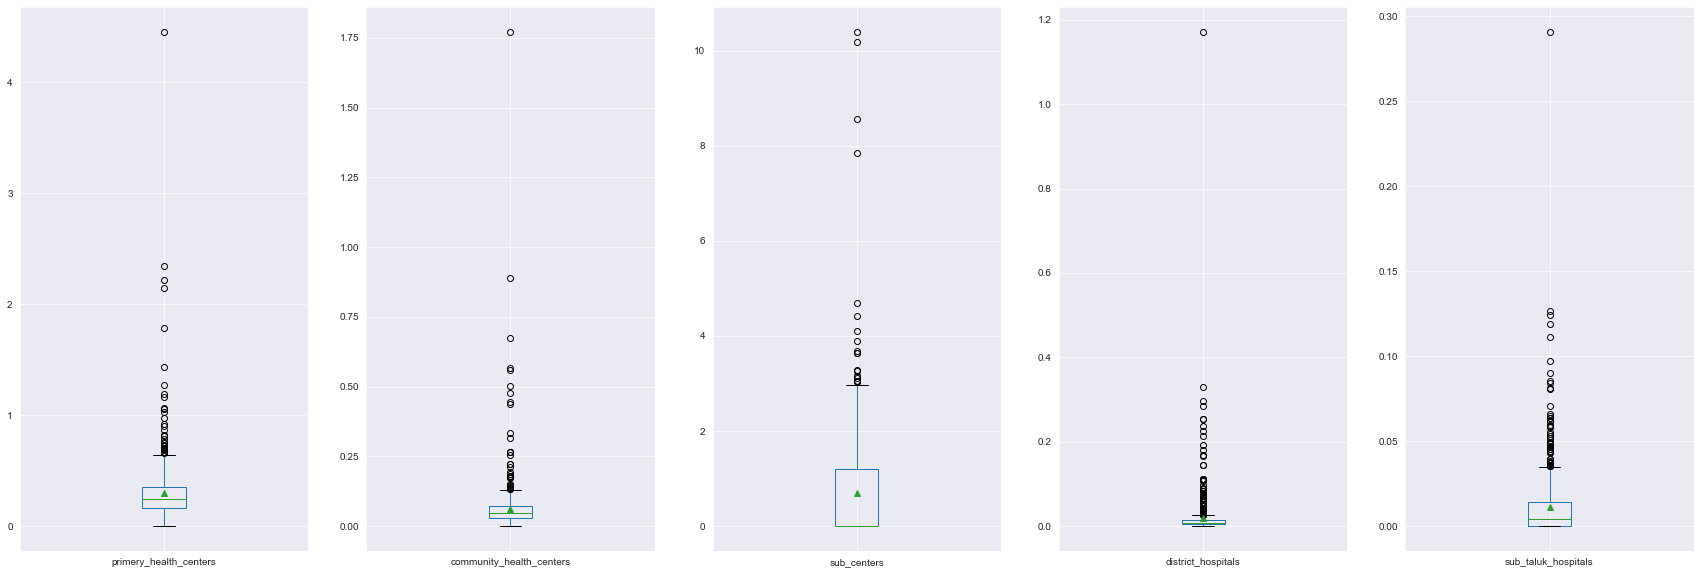

In [6]:
# Figure style
sns.set_style("dark")
# Create figure and axes (this time it's 15, arranged 5 by 3)
f, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 10))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(all_indicators):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    health_infra_df.boxplot(column=col, showmeans=True, ax=ax)
# Display the figure
plt.show()

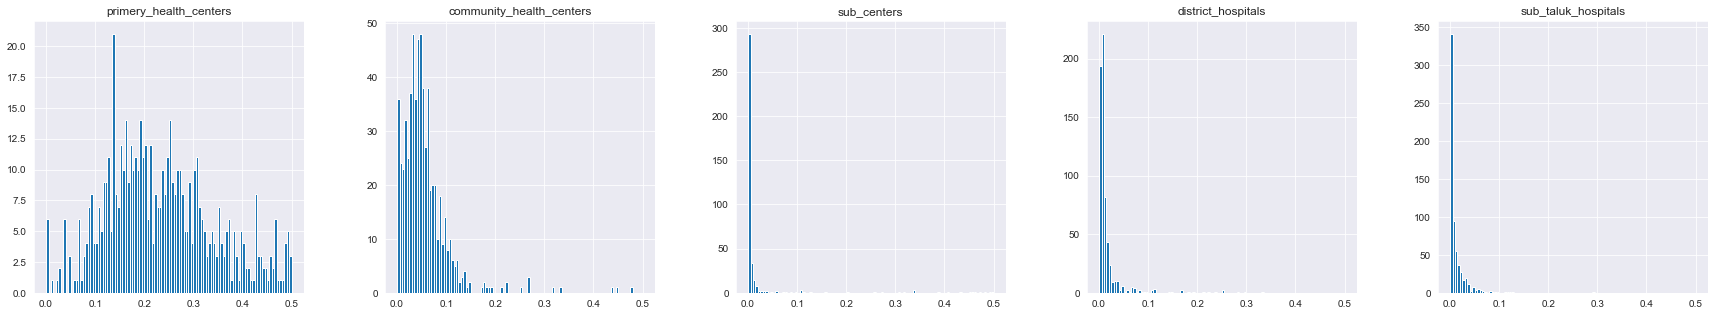

In [7]:
# Figure style
sns.set_style("darkgrid")
# Create figure and axes (this time it's 15, arranged 5 by 3)
f, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 5))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(all_indicators):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    health_infra_df.hist(column=col,bins=100, range=(0,0.5), ax=ax)
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

### Shape file
- Loading
- Dropping unnecessary columns
- Ploting the map

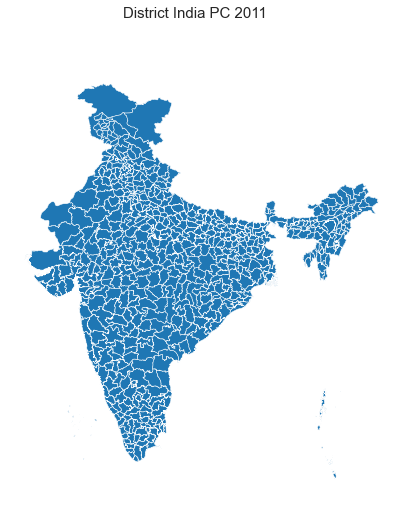

,censuscode,geometry
0,532,"POLYGON ((78.84972 19.76010, 78.85102 19.75945..."
1,146,"POLYGON ((78.19803 27.40280, 78.19804 27.40278..."
2,474,"MULTIPOLYGON (((72.03456 23.50527, 72.03337 23..."
3,522,"POLYGON ((74.67333 19.94670, 74.67393 19.93509..."
4,283,"POLYGON ((92.98749 24.40453, 92.99107 24.40236..."


In [51]:
# Loding the shape file
geo_map = gpd.read_file('data/ShapeFiles/2011_Dist.shp')

# Droping columns
geo_map = geo_map.drop([ 'DISTRICT', 'ST_NM', 'ST_CEN_CD', 'DT_CEN_CD'], axis=1 )

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(8, 8))
# Add a layer with polygons on to axis `ax`
geo_map.plot(linewidth=0.5, ax=ax)
# Remove axis frame
ax.set_axis_off()
# Title
f.suptitle('District India PC 2011', size=15)
# Display
plt.show()

# Display top of table
geo_map.head()

### Joining the data
- Joing the shape file and the health infrastructure data
- Renaming the 'censuscode' column

In [52]:
#Joining data 
health_infra = geo_map.join(health_infra_df, on = 'censuscode')

# renameing columns
health_infra = health_infra.rename(columns = {'censuscode' : 'pc11_district_id'})                                            

# Display top of table
health_infra.head()

,pc11_district_id,geometry,pc11_state_id,primery_health_centers,community_health_centers,sub_centers,district_hospitals,sub_taluk_hospitals
0,532,"POLYGON ((78.84972 19.76010, 78.85102 19.75945...",28.0,0.468578,0.017101,0.731940,0.003420,0.020522
1,146,"POLYGON ((78.19803 27.40280, 78.19804 27.40278...",9.0,0.163379,0.033949,0.002122,0.006365,0.000000
2,474,"MULTIPOLYGON (((72.03456 23.50527, 72.03337 23...",24.0,0.135161,0.015596,0.309311,0.003899,0.003899
3,522,"POLYGON ((74.67333 19.94670, 74.67393 19.93509...",27.0,0.290984,0.049529,0.000000,0.002064,0.006191
4,283,"POLYGON ((92.98749 24.40453, 92.99107 24.40236...",15.0,0.351321,0.046843,0.000000,0.023421,0.046843


In [53]:
# General info
health_infra.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   pc11_district_id          641 non-null    int64   
 1   geometry                  641 non-null    geometry
 2   pc11_state_id             640 non-null    float64 
 3   primery_health_centers    640 non-null    float32 
 4   community_health_centers  640 non-null    float32 
 5   sub_centers               640 non-null    float32 
 6   district_hospitals        640 non-null    float32 
 7   sub_taluk_hospitals       640 non-null    float32 
dtypes: float32(5), float64(1), geometry(1), int64(1)
memory usage: 27.7 KB


In [54]:
# number of NaN values per column
health_infra.isnull().sum()

pc11_district_id            0
geometry                    0
pc11_state_id               1
primery_health_centers      1
community_health_centers    1
sub_centers                 1
district_hospitals          1
sub_taluk_hospitals         1
dtype: int64

In [55]:
# dropping all rows with missing data
health_infra = health_infra.dropna(axis=0)

### EDA

Source explaining the different types of hospitals: https://www-ncbi-nlm-nih-gov.tudelft.idm.oclc.org/pmc/articles/PMC5144115/
- 'sub-centres' are the lowest type of health care centers 

In [13]:
main_indicators = ['primery_health_centers','community_health_centers','district_hospitals','sub_taluk_hospitals']
all_indicators = ['primery_health_centers','community_health_centers','sub_centers','district_hospitals','sub_taluk_hospitals']

In [56]:
health_infra.describe()

,pc11_district_id,pc11_state_id,primery_health_centers,community_health_centers,sub_centers,district_hospitals,sub_taluk_hospitals
count,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000
mean,320.500000,17.114062,0.297052,0.062479,0.698854,0.018468,0.011016
std,184.896367,9.426486,0.287464,0.099366,1.150003,0.057902,0.020868
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,160.750000,9.000000,0.159362,0.028572,0.000000,0.004302,0.000000
50%,320.500000,18.000000,0.240226,0.046316,0.008252,0.007258,0.003896
75%,480.250000,24.000000,0.351808,0.070428,1.196458,0.013279,0.013957
max,640.000000,35.000000,4.455616,1.771778,10.396439,1.171390,0.290844


In [15]:
health_infra.sort_values(by=['district_hospitals','sub_taluk_hospitals','community_health_centers','primery_health_centers','sub_centers' ],ascending=False)

,pc11_district_id,geometry,pc11_state_id,primery_health_centers,community_health_centers,sub_centers,district_hospitals,sub_taluk_hospitals
154,257,"POLYGON ((96.43499 28.58840, 96.30359 28.66189...",12.0,0.000000,0.000000,4.685560,1.171390,0.000000
409,94,"POLYGON ((77.26042 28.62286, 77.26267 28.62114...",7.0,1.782673,0.000000,0.000000,0.330125,0.066025
331,25,"POLYGON ((76.79634 33.25490, 76.80351 33.25275...",2.0,4.455616,0.891123,10.396439,0.297041,0.000000
172,251,"POLYGON ((95.38511 28.31044, 95.38870 28.30773...",12.0,0.756007,0.567005,2.835025,0.283502,0.000000
637,638,"MULTIPOLYGON (((93.84861 7.24051, 93.84870 7.2...",35.0,1.272434,0.254487,10.179475,0.254487,0.000000
...,...,...,...,...,...,...,...,...
329,256,"POLYGON ((94.01886 27.95492, 94.01363 27.94966...",12.0,0.101827,0.000000,0.203654,0.000000,0.000000
515,205,"POLYGON ((85.26710 26.39917, 85.26517 26.39992...",10.0,0.085722,0.000000,0.128583,0.000000,0.000000
313,342,"POLYGON ((88.41075 22.55997, 88.40914 22.55744...",19.0,0.002085,0.000000,0.004170,0.000000,0.000000
485,58,"POLYGON ((79.27897 30.72611, 79.28977 30.72314...",5.0,0.000000,0.000000,0.000000,0.000000,0.000000


C:\Users\ASUS\miniconda3\envs\gds\lib\site-packages\mapclassify\classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\Users\ASUS\miniconda3\envs\gds\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


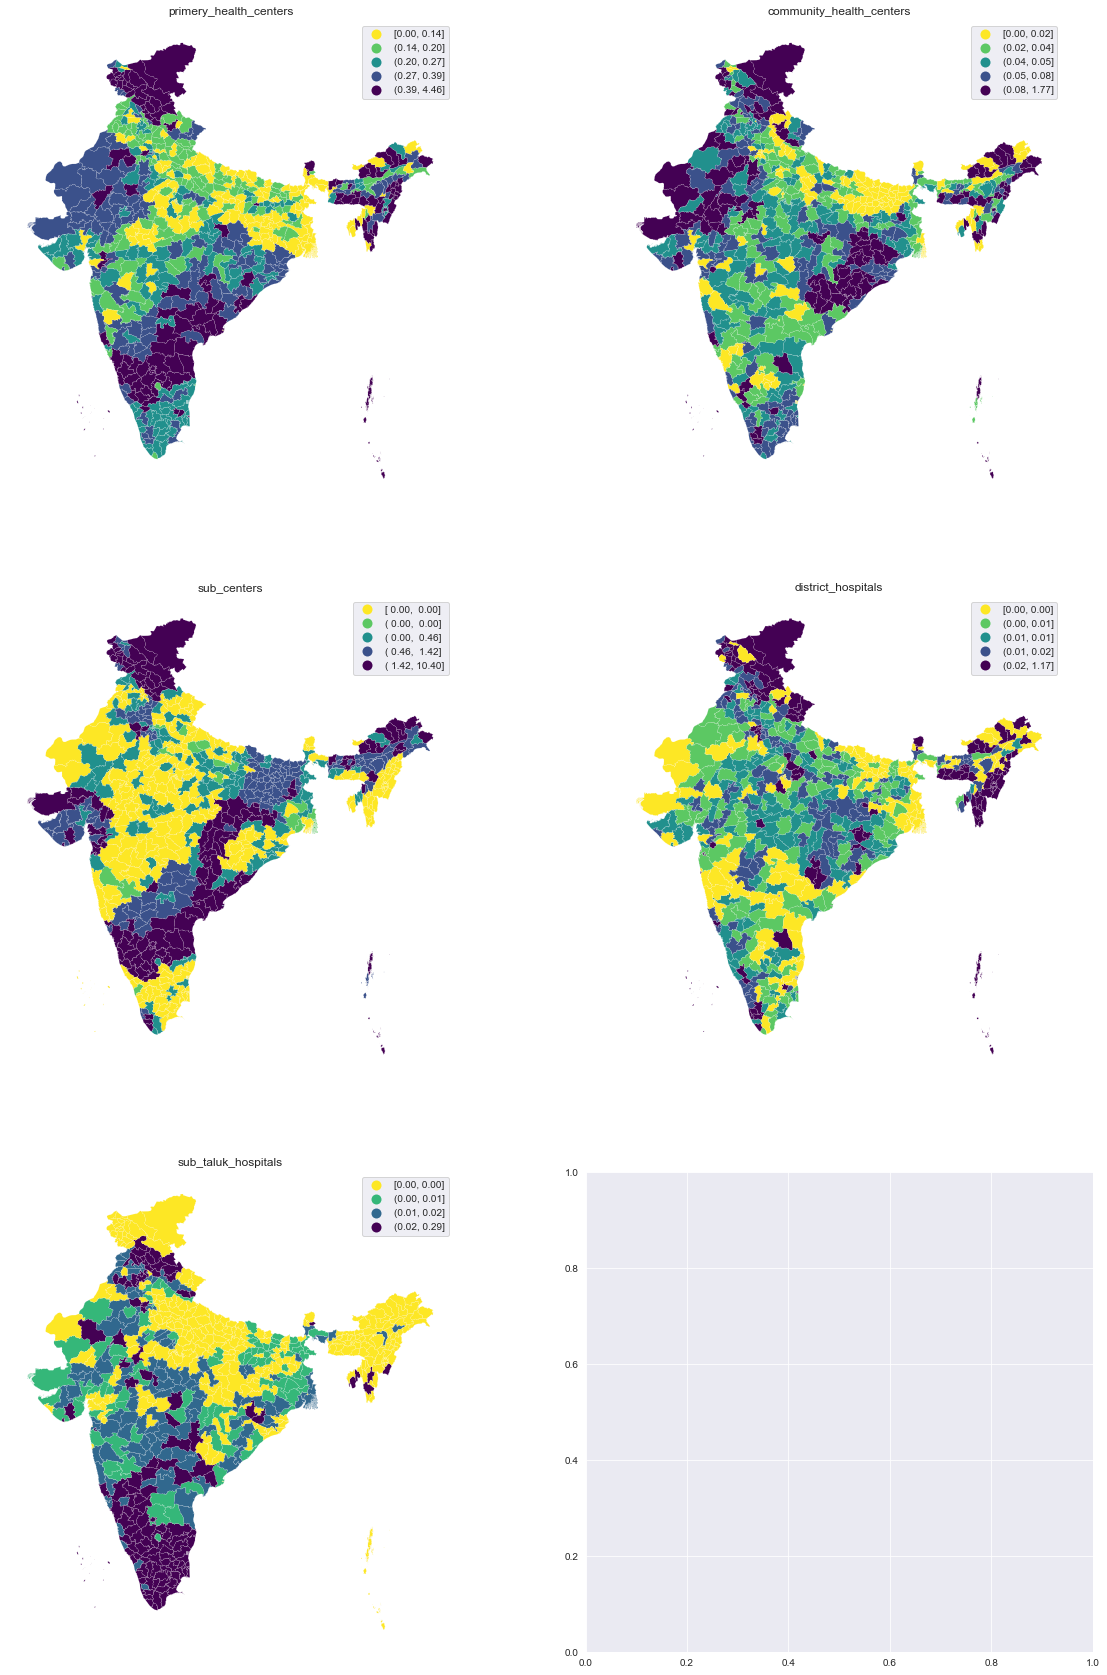

In [16]:
title = ['Primery Health Centers', 'Community Health Centers', 'Sub-centres', 'District Hospitals', 'Sub-district/Taluk hospitals' ]
# Create figure and axes (this time it's 4, arranged 2 by 2)
f, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 30))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(all_indicators):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    health_infra.plot(column=col, ax=ax, edgecolor='w', \
             linewidth=0.1, cmap='viridis_r', scheme='Quantiles', alpha=1, legend=True)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

***To classify the areas by health care access, K-means clustering algorithm will be used. Because on this stage we are not sure about the importance of the sub-centers to efficiency of the system two clustering algorithms will be made one with (all_indicators) the sub-centers and one without(main_indicators)***

### Main indicators - all without 'sub-centers'


In [157]:
# setting number of clusters
kmeans6 = cluster.KMeans(n_clusters=6)
kmeans6

KMeans(n_clusters=6)

***To run the algorithm the fit() method will be used***

In [158]:
# This line is required to obtain the same results always. 
#(Computers are not truly random. They only seem that way. If this is interesting for you, ask me in class ;) Or try with a different seed.
np.random.seed(2000)
# Run the clustering algorithm
k6cls = kmeans6.fit(health_infra[main_indicators])

In [159]:
k6cls.labels_

array([3, 5, 5, 0, 0, 0, 5, 0, 5, 5, 5, 0, 0, 5, 5, 5, 0, 5, 0, 0, 3, 4,
       0, 0, 5, 0, 5, 5, 0, 5, 5, 3, 0, 0, 5, 5, 0, 5, 0, 0, 5, 5, 0, 0,
       0, 3, 5, 5, 5, 0, 5, 0, 3, 0, 5, 5, 0, 5, 5, 0, 0, 5, 5, 0, 5, 0,
       0, 5, 0, 5, 0, 0, 0, 0, 0, 5, 0, 5, 5, 5, 0, 0, 0, 5, 0, 0, 1, 5,
       0, 5, 0, 5, 5, 0, 0, 5, 5, 5, 3, 3, 5, 5, 1, 3, 5, 3, 0, 0, 0, 5,
       5, 5, 0, 3, 3, 3, 3, 0, 0, 0, 0, 3, 5, 5, 3, 0, 0, 3, 5, 0, 5, 5,
       5, 5, 5, 5, 3, 0, 5, 5, 5, 5, 3, 0, 5, 5, 0, 0, 0, 0, 0, 5, 5, 5,
       5, 0, 0, 5, 3, 0, 0, 0, 0, 5, 0, 5, 3, 3, 1, 3, 0, 1, 0, 0, 5, 5,
       5, 5, 5, 5, 5, 0, 5, 5, 5, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 5, 5, 5,
       5, 0, 5, 0, 5, 0, 5, 5, 0, 5, 5, 0, 5, 0, 5, 5, 3, 0, 0, 5, 5, 5,
       5, 3, 5, 0, 5, 5, 5, 5, 0, 5, 0, 0, 3, 5, 5, 5, 0, 3, 0, 0, 0, 5,
       0, 5, 5, 0, 5, 0, 5, 5, 5, 0, 0, 5, 5, 0, 0, 0, 0, 3, 0, 0, 5, 5,
       0, 5, 5, 0, 0, 5, 5, 3, 3, 3, 5, 5, 0, 5, 5, 5, 5, 0, 1, 5, 0, 5,
       0, 0, 3, 5, 5, 0, 0, 0, 5, 3, 5, 5, 0, 5, 4,

***Each number is different category***

In [160]:
health_infra['k6cls'] = k6cls.labels_

***Evaluation of the number of the clusters will be made by using the Elbow Method - the elbow method serves to determine the optimal number of clusters.***

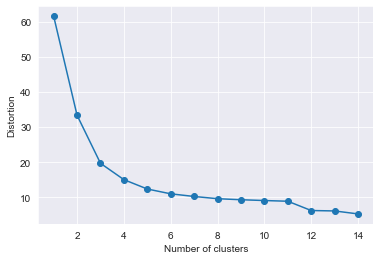

In [150]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 15):
    kmeans=KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    ) 
    kmeans.fit(health_infra[main_indicators])
    distortions.append(kmeans.inertia_)

# plot
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


### Mapping the categories

At this point it is helpful to see the geographical distribution of the categories.


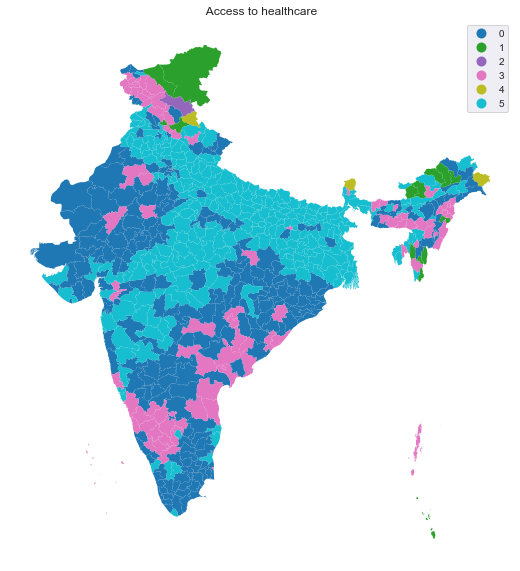

In [161]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot unique values choropleth including a legend and with no boundary lines
health_infra.plot(column='k6cls', categorical=True, legend=True ,linewidth=0, ax=ax)

# Remove axis
ax.set_axis_off()
# Add title
plt.title(' Access to healthcare')

# Display the map
plt.show()

- 0 (dark blue) - Areas with second lowest number of healthcare facilities per 10 000 people
- 1 (green) - Areas with high number of healthcare facilities per 10 000 people
- 2 - Areas with highest number of healthcare facilities per 10 000 people (only 1 district) - no 'sub_taluk_hospitals'
- 3 (red-brown)- Areas with relatively high number of healthcare facilities per 10 000 people
- 4 - Areas with second highest number of healthcare facilities per 10 000 people (4 district)
- 5 (pink) - Areas with lowest number of healthcare facilities per 10 000 people


In [162]:
k6sizes = health_infra.groupby('k6cls').size()
k6sizes

k6cls
0    243
1     15
2      1
3     94
4      4
5    283
dtype: int64

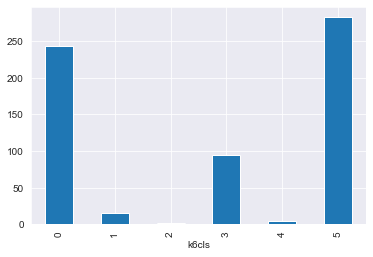

In [163]:
_ = k6sizes.plot.bar()

In [165]:
# Calculate the mean by group
k6means = health_infra.groupby('k6cls')[main_indicators].mean()
# Show the table transposed (so it's not too wide)
k6means.T

k6cls,0,1,2,3,4,5
primery_health_centers,0.295344,1.002083,4.455616,0.531252,2.120757,0.142887
community_health_centers,0.063864,0.288902,0.891123,0.078537,0.554401,0.034074
district_hospitals,0.010777,0.114534,0.297041,0.031176,0.164022,0.012717
sub_taluk_hospitals,0.012997,0.010083,0.000000,0.020734,0.044370,0.005704


In [166]:
# Name (index) the rows after the category they belong
to_plot =  health_infra.set_index('k6cls')
# Subset to keep only variables used in K-means clustering
to_plot = to_plot[main_indicators]
# Display top of the table
to_plot.head()

,primery_health_centers,community_health_centers,district_hospitals,sub_taluk_hospitals
k6cls,,,,
3,0.468578,0.017101,0.003420,0.020522
5,0.163379,0.033949,0.006365,0.000000
5,0.135161,0.015596,0.003899,0.003899
0,0.290984,0.049529,0.002064,0.006191
0,0.351321,0.046843,0.023421,0.046843


In [167]:
to_plot = to_plot.stack()
to_plot.head()

k6cls                          
3      primery_health_centers      0.468578
       community_health_centers    0.017101
       district_hospitals          0.003420
       sub_taluk_hospitals         0.020522
5      primery_health_centers      0.163379
dtype: float32

In [168]:
to_plot = to_plot.reset_index()
to_plot.head()

,k6cls,level_1,0
0,3,primery_health_centers,0.468578
1,3,community_health_centers,0.017101
2,3,district_hospitals,0.003420
3,3,sub_taluk_hospitals,0.020522
4,5,primery_health_centers,0.163379


In [169]:
to_plot = to_plot.rename(columns={'level_1': 'Indicator', 0: 'Value'})
to_plot.head()


,k6cls,Indicator,Value
0,3,primery_health_centers,0.468578
1,3,community_health_centers,0.017101
2,3,district_hospitals,0.003420
3,3,sub_taluk_hospitals,0.020522
4,5,primery_health_centers,0.163379


C:\Users\ASUS\miniconda3\envs\gds\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ASUS\miniconda3\envs\gds\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ASUS\miniconda3\envs\gds\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ASUS\miniconda3\envs\gds\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


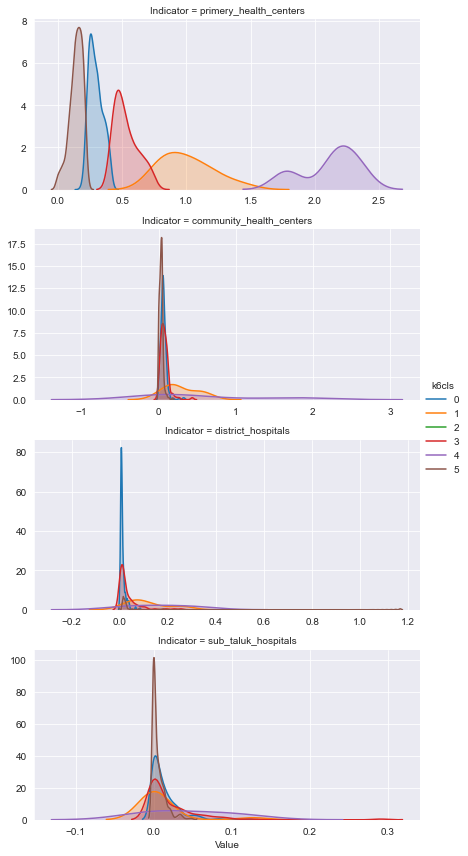

In [170]:
# Setup the facets
facets = sns.FacetGrid(data=to_plot, row='Indicator', hue='k6cls', \
                  sharey=False, sharex=False, aspect=2)
# Build the plot as a `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Value', shade=True).add_legend()

### All indicators - include the 'sub-centers'


In [127]:
# setting number of clusters
kmeans4 = cluster.KMeans(n_clusters=4)
kmeans4

KMeans(n_clusters=4)

***To run the algorithm the fit() method will be used***

In [128]:
# This line is required to obtain the same results always. 
#(Computers are not truly random. They only seem that way. If this is interesting for you, ask me in class ;) Or try with a different seed.
np.random.seed(2000)
# Run the clustering algorithm
k4cls = kmeans4.fit(health_infra[all_indicators])

***Each number is different category***

In [129]:
health_infra['k4cls'] = k4cls.labels_

***Evaluation of the number of the clusters will be made by using the Elbow Method - the elbow method serves to determine the optimal number of clusters.***

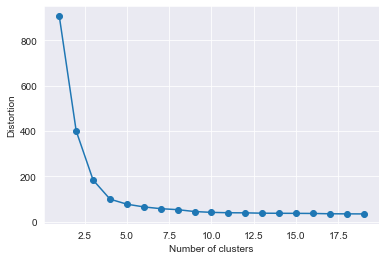

In [34]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 20):
    kmeans=KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    ) 
    kmeans.fit(health_infra[all_indicators])
    distortions.append(kmeans.inertia_)

# plot
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()


***4 is the number where the line stop descending***

### Mapping the categories

At this point it is helpful to see the geographical distribution of the categories.


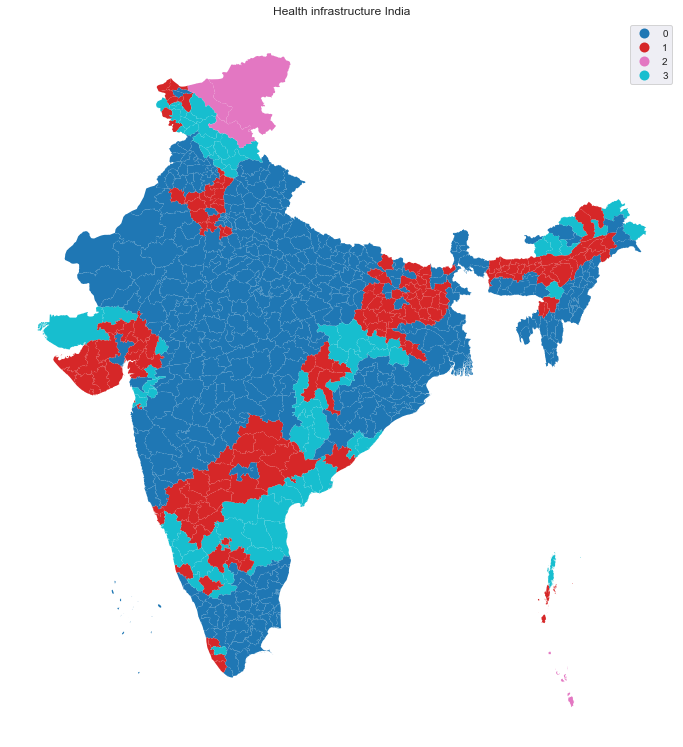

In [130]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(12, 15))
# Plot unique values choropleth including a legend and with no boundary lines
health_infra.plot(column='k4cls', categorical=True, legend=True ,linewidth=0, ax=ax)

# Remove axis
ax.set_axis_off()
# Add title
plt.title('Health infrastructure India')

# Display the map
plt.show()

- 0 (dark blue) - Areas with second lowest number of healthcare facilities per 10 000 people, lowest number of sub center
- 1 (green) - Areas with low number of healthcare facilities per 10 000 people
- 2 - Areas with highest number of healthcare facilities per 10 000 people (4 district) - no 'sub_taluk_hospitals'
- 3 (pink)- Areas withhigh number of healthcare facilities per 10 000 people

### Exploring the nature of the categories

Some statisticasl exploraation will be reqaired as well 
- Count
- Mean
- Discribe 
- Distribution

In [131]:
k4sizes = health_infra.groupby('k4cls').size()
k4sizes

k4cls
0    403
1    155
2      4
3     78
dtype: int64

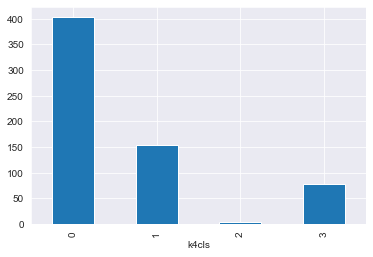

In [132]:
_ = k4sizes.plot.bar()

In [133]:
# Calculate the mean by group
k4means = health_infra.groupby('k4cls')[all_indicators].mean()
# Show the table transposed (so it's not too wide)
k4means.T

k4cls,0,1,2,3
primery_health_centers,0.249169,0.259928,1.961758,0.532853
community_health_centers,0.052052,0.047427,0.405669,0.128668
sub_centers,0.041867,1.234666,9.250588,2.589978
district_hospitals,0.015943,0.010461,0.172089,0.039545
sub_taluk_hospitals,0.011032,0.007396,0.000000,0.018690


In [134]:
# Name (index) the rows after the category they belong
to_plot = health_infra.set_index('k5cls')
# Subset to keep only variables used in K-means clustering
to_plot = to_plot[all_indicators]
# Display top of the table
to_plot.head()

,primery_health_centers,community_health_centers,sub_centers,district_hospitals,sub_taluk_hospitals
k5cls,,,,,
2,0.468578,0.017101,0.731940,0.003420,0.020522
0,0.163379,0.033949,0.002122,0.006365,0.000000
0,0.135161,0.015596,0.309311,0.003899,0.003899
2,0.290984,0.049529,0.000000,0.002064,0.006191
2,0.351321,0.046843,0.000000,0.023421,0.046843


***When the sub-centers are included the cluster classification changes completely!***

In [140]:
# Name (index) the rows after the category they belong
to_plot =  health_infra.set_index('k4cls')
# Subset to keep only variables used in K-means clustering
to_plot = to_plot[all_indicators]
# Display top of the table
to_plot.head()

,primery_health_centers,community_health_centers,sub_centers,district_hospitals,sub_taluk_hospitals
k4cls,,,,,
1,0.468578,0.017101,0.731940,0.003420,0.020522
0,0.163379,0.033949,0.002122,0.006365,0.000000
0,0.135161,0.015596,0.309311,0.003899,0.003899
0,0.290984,0.049529,0.000000,0.002064,0.006191
0,0.351321,0.046843,0.000000,0.023421,0.046843


In [141]:
to_plot = to_plot.stack()
to_plot.head()

k4cls                          
1      primery_health_centers      0.468578
       community_health_centers    0.017101
       sub_centers                 0.731940
       district_hospitals          0.003420
       sub_taluk_hospitals         0.020522
dtype: float32

In [142]:
to_plot = to_plot.reset_index()
to_plot.head()

,k4cls,level_1,0
0,1,primery_health_centers,0.468578
1,1,community_health_centers,0.017101
2,1,sub_centers,0.731940
3,1,district_hospitals,0.003420
4,1,sub_taluk_hospitals,0.020522


In [143]:
to_plot = to_plot.rename(columns={'level_1': 'Indicator', 0: 'Value'})
to_plot.head()


,k4cls,Indicator,Value
0,1,primery_health_centers,0.468578
1,1,community_health_centers,0.017101
2,1,sub_centers,0.731940
3,1,district_hospitals,0.003420
4,1,sub_taluk_hospitals,0.020522


C:\Users\ASUS\miniconda3\envs\gds\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


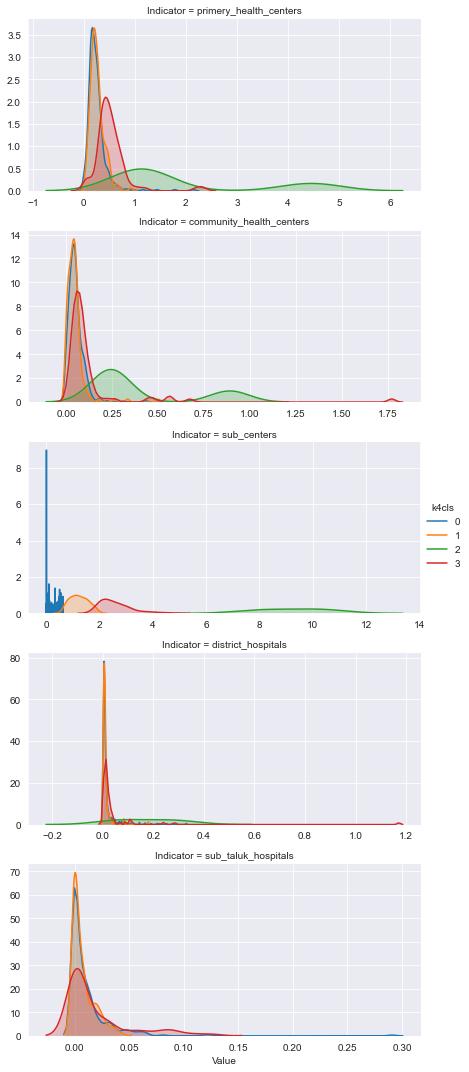

In [144]:
# Setup the facets
facets = sns.FacetGrid(data=to_plot, row='Indicator', hue='k4cls', \
                  sharey=False, sharex=False, aspect=2)
# Build the plot as a `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Value', shade=True).add_legend()